In [1]:
import numpy as np
import cv2

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import time

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is 
data directory is ../human_pose_local/archive/Human Action Recognition


### Load the data

In [3]:
file_name = "movenet_thunder_mobilenet_large"

In [4]:
df = pd.read_pickle(data_directory + '/' + file_name + '.pkl')

In [5]:
# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

In [6]:
df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

In [7]:
df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words,obj_input
0,Image_1.jpg,sitting,11,"[0.0882076621055603, 0.6247615814208984, 0.756...","[[0.60480165], [0.04718776], [0.032203343], [0...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo...","[-0.20592125285495, 0.3260203410991888, -0.008..."
1,Image_2.jpg,using_laptop,14,"[0.30178800225257874, 0.9912914037704468, 0.80...","[[0.7418762], [0.040941585], [0.012892539], [0...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ...","[0.2683790374652541, -0.6670002713657828, 0.87..."
2,Image_3.jpg,hugging,7,"[0.20708897709846497, 0.6019015908241272, 0.42...","[[0.1416007], [0.13604547], [0.05453948], [0.0...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape...","[-0.02030288063444885, 0.23200371996866265, 0...."
3,Image_4.jpg,sleeping,12,"[0.37268558144569397, 0.1374012678861618, 0.20...","[[0.6505104], [0.06191667], [0.027490702], [0....","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia...","[-0.8215984234954313, -0.02994576481942718, -0..."
4,Image_5.jpg,using_laptop,14,"[0.03276867792010307, 0.2222181260585785, 0.79...","[[0.71057284], [0.10088889], [0.035408325], [0...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto...","[-0.1494515264241883, -0.1284101833971808, -0...."
...,...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.04209192469716072, 0.7099579572677612, 0.58...","[[0.23895389], [0.14317973], [0.076097175], [0...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding...","[-0.14739882579379793, 0.2794763101199509, -0...."
12596,Image_12597.jpg,clapping,1,"[0.06415694206953049, 0.705790638923645, 0.468...","[[0.8603377], [0.021510318], [0.016789775], [0...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w...","[0.057619909586660134, 0.26067134955875726, 0...."
12597,Image_12598.jpg,sitting,11,"[0.051420778036117554, 0.4904737174510956, 0.5...","[[0.48068434], [0.07919033], [0.043129846], [0...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho...","[-0.001942008389194727, -0.2787240437545768, -..."
12598,Image_12599.jpg,dancing,3,"[0.2283279001712799, 0.42992380261421204, 0.62...","[[0.15199172], [0.068358354], [0.059058633], [...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]...","[0.014005273690095521, 0.06621338508228547, -0..."


In [8]:
def train_test_split_df(df, test_perc): 
    
    n_classes = df['category'].nunique()
    
    n_samples = int(len(df)*test_perc/n_classes)
    
    test_df = df.groupby('category').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)

    # split the dataframe in train and test by the column 'filename'

    train_df = df[~df['filename'].isin(test_df['filename'])]
    
    return train_df, test_df

In [9]:
train_df, test_df = train_test_split_df(df, 0.2)

In [10]:
def create_dataset(df, use_object=True):
    
    labels = df['category']
    
    kpoints = df['keypoints']

    # merge the two arrays
    if use_object:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
    else:
        df['input'] = df['keypoints']

    if use_object:
        data = np.zeros((len(kpoints), 17*3+100))
    else:    
        data = np.zeros((len(kpoints), 17*3))
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row)
    
    return data, labels

### GridSearch

In [15]:
kernel = ['rbf']
C = [1, 10, 100]
n_splits = 5

In [16]:
for kr in kernel:
    for c in C:
        print("Fitting SVM")
        print("Kernel", kr)
        print("C", c)
        
        # KFold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        accuracy_per_fold = []

        for train_index, val_index in kf.split(df):
    
            df_train, df_val = df.iloc[train_index], df.iloc[val_index]
    
            # Convert to TensorFlow datasets
            train_dataset, train_labels = create_dataset(df_train)
            val_dataset, val_labels = create_dataset(df_val)
    
            # Create a new instance of the model
            model = SVC(kernel=kr, C=c)

            # Train the model
            results = model.fit(train_dataset, train_labels)
    
            # compute predicted labels
            predicted_labels = model.predict(val_dataset)
    
            # Evaluate the model
            val_accuracy = accuracy_score(val_labels, predicted_labels)
            accuracy_per_fold.append(val_accuracy)
        
        print("Average accuracy:", np.round(np.mean(accuracy_per_fold),3), "±", np.round(np.std(accuracy_per_fold),3))
        print("---------------------------------------------------------")

Fitting SVM
Kernel rbf
C 1
Average accuracy: 0.549 ± 0.01
---------------------------------------------------------
Fitting SVM
Kernel rbf
C 20
Average accuracy: 0.567 ± 0.013
---------------------------------------------------------


### Training on best model

In [17]:
# Number of folds
n_splits = 5

index = 1

# KFold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_per_fold = []
conf_matrix = np.zeros((15,15))


for train_index, val_index in kf.split(df, df['category']):
    
    print("Starting Fold Number", index)
    print()
    
    index += 1
    
    df_train, df_val = df.iloc[train_index], df.iloc[val_index]
    
    # Convert to TensorFlow datasets
    train_dataset, train_labels = create_dataset(df_train)
    val_dataset, val_labels = create_dataset(df_val)
    
    print("Fitting the model:")
    
    start = time.time()
    
    # Create a new instance of the model
    model = SVC(kernel='rbf', C=10)

    # Train the model
    results = model.fit(train_dataset, train_labels)

    end = time.time()
    print('Training time:', round(end-start,2), "s")
    
    # compute predicted labels
    predicted_labels = model.predict(val_dataset)
    
    # compute the confusion matrix
    cm = confusion_matrix(val_labels, predicted_labels)
    #print(cm)
    conf_matrix = conf_matrix + cm
    
    # Evaluate the model
    val_accuracy = accuracy_score(val_labels, predicted_labels)
    print("Accuracy:", round(val_accuracy,3))
    accuracy_per_fold.append(val_accuracy)
    
    print()
    print('-----------------------------------------------------------------')
    print()

Starting Fold Number 1

Fitting the model:
Training time: 6.86 s
Accuracy: 0.587

-----------------------------------------------------------------

Starting Fold Number 2

Fitting the model:
Training time: 6.64 s
Accuracy: 0.571

-----------------------------------------------------------------

Starting Fold Number 3

Fitting the model:
Training time: 7.64 s
Accuracy: 0.565

-----------------------------------------------------------------

Starting Fold Number 4

Fitting the model:
Training time: 7.5 s
Accuracy: 0.59

-----------------------------------------------------------------

Starting Fold Number 5

Fitting the model:
Training time: 7.7 s
Accuracy: 0.567

-----------------------------------------------------------------



In [18]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'

In [19]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, threshold=0.1, val=True):
    #normalize cm
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(11, 6))
    if val:
        ax = sns.heatmap(cm_normalized, annot=False, cmap='Greens', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
        ax.set_title("SVM - Validation Set")
    else:
        ax = sns.heatmap(cm_normalized, annot=False, cmap='Oranges', vmin=0, vmax=1, cbar=True, xticklabels=labels, yticklabels=labels)
        ax.set_title("SVM - Test Set")
    
    # Annotate only the main diagonal with rounded values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j or cm_normalized[i, j] > threshold:
                if cm_normalized[i, j] < 0.7:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='black', fontsize=14)
                else:
                    ax.text(j + 0.5, i + 0.5, f'{cm_normalized[i, j]:.2f}', 
                            ha='center', va='center', color='white', fontsize=14)    
                
    # Labels, title and axes
    ax.set_xlabel('Predicted labels', fontsize = 14)
    ax.set_ylabel('True labels', fontsize = 14)
    plt.xticks(rotation=60)
    
    plt.show()

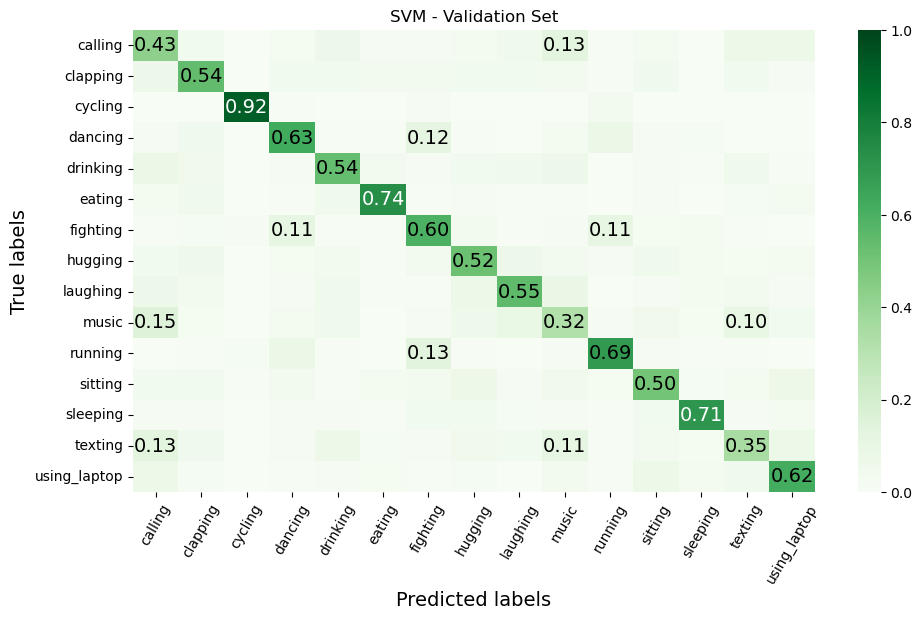

In [20]:
plot_confusion_matrix(conf_matrix)

In [21]:
def class_specific_metrics(cm, class_labels = labels):

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [22]:
val_metrics = class_specific_metrics(conf_matrix)
val_metrics

,Accuracy,Sensitivity,Specificity,Precision
calling,0.912143,0.428571,0.946684,0.364742
clapping,0.938413,0.539286,0.966922,0.538005
cycling,0.990238,0.920238,0.995238,0.932449
dancing,0.946270,0.626190,0.969133,0.591676
drinking,0.938492,0.535714,0.967262,0.538922
eating,0.968810,0.738095,0.985289,0.781841
fighting,0.938492,0.596429,0.962925,0.534685
hugging,0.933571,0.521429,0.963010,0.501718
laughing,0.941905,0.547619,0.970068,0.566502
music,0.911825,0.321429,0.953997,0.332922


### Test set

In [23]:
train_dataset, train_labels = create_dataset(train_df)

# Create a new instance of the model
model = SVC(kernel='rbf', C=10)

# Train the model
results = model.fit(train_dataset, train_labels)

In [24]:
test_dataset, test_labels = create_dataset(test_df)

In [25]:
# compute predicted labels
predicted_labels = model.predict(test_dataset)
    
# compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
    
# Evaluate the model
val_accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", round(val_accuracy,3))

Accuracy: 0.574


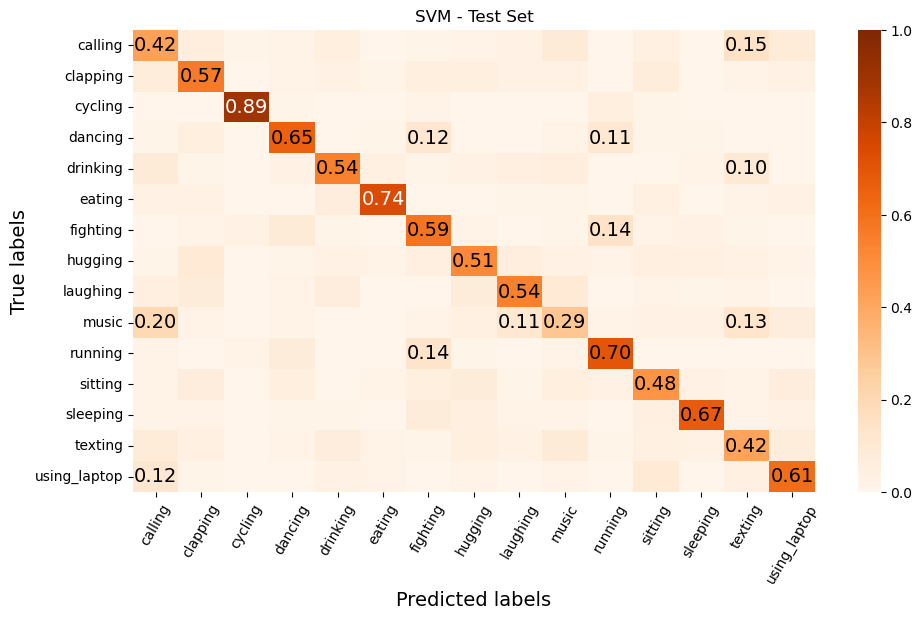

In [26]:
plot_confusion_matrix(cm, val=False)

In [27]:
test_metrics = class_specific_metrics(cm)
test_metrics

,Accuracy,Sensitivity,Specificity,Precision
calling,0.911905,0.422619,0.946854,0.362245
clapping,0.936905,0.565476,0.963435,0.524862
cycling,0.986508,0.886905,0.993622,0.908537
dancing,0.950000,0.654762,0.971088,0.617978
drinking,0.943651,0.541667,0.972364,0.583333
eating,0.971032,0.738095,0.987670,0.810458
fighting,0.934127,0.589286,0.958759,0.505102
hugging,0.937302,0.511905,0.967687,0.530864
laughing,0.945238,0.541667,0.974065,0.598684
music,0.915079,0.285714,0.960034,0.338028
